# Airbnb vs Hotel - what is the better lodging option?

We chose the following cities for a comparison of Airbnb listing factors. Airbnb listing data was captured for each city on the date indicated:
* Amsterdam (March 7, 2019)
* Beijing (February 11, 2019)
* Las Vegas (February 13, 2019)
* Los Angeles (March 6, 2019)
* Madrid (March 8, 2019)
* New York (March 6, 2019)
* Paris (February 5, 2019)
* Sydney (March 7, 2019)

These cities were chosen subjectively, influenced by a desire to include well-known pleasure destinations worldwide, to have representation outside the US, and for availability of data. 

Airbnb data repositories for these cities, including listing csv files and geoJSON data, were downloaded from the website Inside Airbnb (http://insideairbnb.com/get-the-data.html ). Hotel data was downloaded from a 2016 free World Hotel dataset here https://github.com/lucasmonteiro001/free-world-hotel-database/blob/master/hotels.csv.zip for some analysis and geographic comparison. Further hotel data was scraped from TripAdvisor (https://www.tripadvisor.com) on March 28, 2019.

For more details, images, and further exploration of the data, please see the following notebooks:

* airbnb/AirBnBnotebook.ipynb
* airbnb/Airbnb-Qualitative.ipynb
* hotel-tripadvisor/hotelScraped.ipynb
* Hotels_Analysis/Hotels.ipynb

---

In [18]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import math
import json
import scipy.stats as stats

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# gmaps and geojson
import geopy.distance
import gmaps
import gmaps.geojson_geometries

# Google developer API key
from config import gkey
gmaps.configure(api_key=gkey)

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# List of Eight World Cities Chosen
cityL=["Amsterdam","Beijing","Las Vegas","Los Angeles","Madrid","New York","Paris","Sydney"]

# carefully selected theme colors for each city
colordict = {"Amsterdam":"darkorange", "Beijing":"crimson", "Las Vegas":"goldenrod", "Los Angeles":"dodgerblue", 
             "Madrid":"gold", "New York":"darkblue", "Paris":"hotpink","Sydney":"lightskyblue"}

# retrieve geography coords
geo_data_file = os.path.join("Resources","geocodes.csv")
geodf = pd.read_csv(geo_data_file, index_col = "city")

## What is the better lodging option, Airbnb or hotel? 

Load the data and compare average price and rating for each type of lodging in each city below

In [19]:
# load the filtered double-occupancy airbnb listings file
airbnb_doublefile = os.path.join("airbnb","saveData","airbnb_double.csv")
airdf = pd.read_csv(airbnb_doublefile).drop(columns=['Unnamed: 0'])

# load the filtered hotel listings file
hotel_file = os.path.join("hotel-tripadvisor","saveData","hotelCity.csv")
hoteldf = pd.read_csv(hotel_file).drop(columns=['Unnamed: 0'])

# load city mean data file
both_file = os.path.join("hotel-tripadvisor","saveData","bothmean.csv")
bothmeandf = pd.read_csv(both_file, index_col="key")
bothmeandf

,hotel_price,hotel_rating,airbnb price,airbnb rating
key,,,,
Amsterdam,243.514793,83.491124,118.276573,95.157141
Beijing,89.730417,76.429298,343.631634,94.917943
Las Vegas,173.022346,73.851351,72.100719,95.489209
Los Angeles,187.151442,70.212202,96.618328,95.039733
Madrid,135.358369,80.988506,55.246704,92.673296
New York,219.503417,82.041284,109.047070,94.055740
Paris,181.812261,84.378378,77.281388,92.974650
Sydney,138.771318,72.901786,112.729176,93.509404


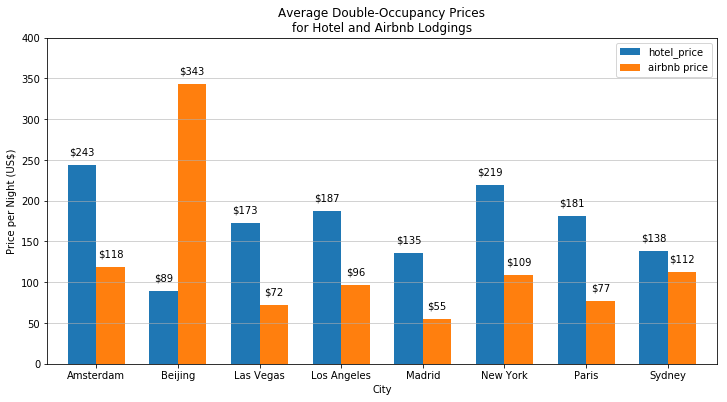

In [20]:
# Plot to compare mean price hotel and Airbnb values

# bar labeler function
def labelbar(bar, label, **kwargs):
    height = bar.get_height()
    if not 'pos' in kwargs:
        pos = "top"
    else:
        pos = kwargs["pos"]
    if not 'ybot' in kwargs:
        ybot = 0
    else:
        ybot = kwargs["ybot"]
    offset = 16*abs(height)/height
    if (pos == "top"):
        placement = height+offset -ybot
    else:
        placement = offset
    plt.text(bar.get_x() + bar.get_width() / 2, placement, label,
            ha='center', va='center', color="black")
    
myplot = bothmeandf[["hotel_price","airbnb price"]].plot(kind='bar', figsize = (12,6), width=.7)
plt.xlabel("City")
plt.ylabel("Price per Night (US$)")
plt.xticks(rotation=0)
plt.title (f"Average Double-Occupancy Prices{os.linesep}for Hotel and Airbnb Lodgings")
plt.grid(axis='y', alpha=.7)
plt.ylim(0,400)


# Make some labels
vals = [*bothmeandf['hotel_price'], *bothmeandf['airbnb price']]
labels = ["$"+str(int(val))  for val in vals]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# This image is saved at the path below
# imagepath = os.path.join("hotel-tripadvisor",saveImages","AverageHotelandAirbnb.png")
# plt.savefig(imagepath)

plt.show()

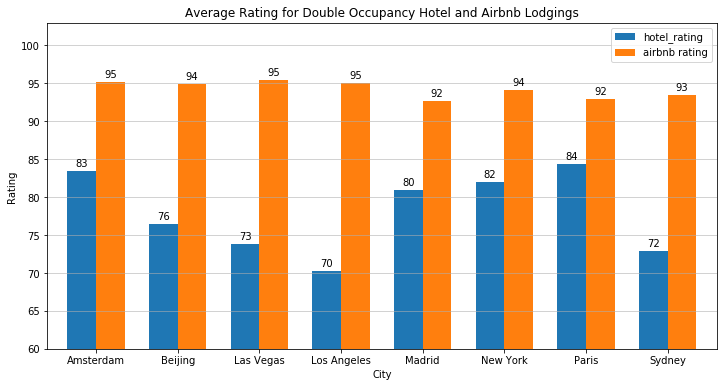

In [21]:
# Plot to compare mean rating hotel and Airbnb values

myplot = bothmeandf[["hotel_rating","airbnb rating"]].plot(kind='bar', figsize = (12,6), width=.7)
plt.xlabel("City")
plt.ylabel("Rating")
plt.xticks(rotation=0)
plt.title (f"Average Rating for Double Occupancy Hotel and Airbnb Lodgings")
plt.grid(axis='y', alpha=.7)
plt.ylim(60,103)

# Make some labels
vals = [*bothmeandf['hotel_rating'], *bothmeandf['airbnb rating']]
labels = [str(int(val)) for val in vals]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label, ybot=15)

# This image is saved at the path below
# imagepath = os.path.join("hotel-tripadvisor","saveImages","HotelAirbnbRating.png")
# plt.savefig(imagepath)

plt.show()

## Analysis

Judging from price and rating scores, Airbnb appears to be the better choice for lodging in most cities. In all 8, Airbnb average ratings are higher than ratings for hotels, but we view the ratings comparison warily for two reasons:
* This hotel data set used a 5-star rating system, which we converted to a 100-point scale. The smallest increment of difference was a half star, which means there were no values between 10-point increments in the converted rating.
* Airbnb hosts and guests rely on reviews to rent properties. Hosts and guests review each other, and our team members have personally experienced incentives being given to give high reviews
Since all city Airbnb ratings are high and close together, we look to the hotel rating data to  make a shaky hypothesis that lodgers are most happy in Paris and Amsterdam, and least happy in LA.

Regarding price, Airbnb accommodations were cheaper on average in all world cities except for Beijing. Staying at a hotel appears to be the much better choice economically in Beijing. We do not know the factors influencing this, but have guessed Airbnb lodgings may not be as popular, culturally accepted, or readily available in Beijing as in other world cities.

Our initial expectation was that we would find Airbnb lodgings to be cheaper than hotels everywhere. When statistically comparing hotel and airbnb prices in each city, we were surprised to find that these prices are close enough to be considered the same in Sydney. See histogram figures below.

---

Amsterdam:
t-test pvalue = 9.591664032389106e-25
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Beijing:
t-test pvalue = 1.9542924501970783e-13
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Las Vegas:
t-test pvalue = 2.54877892420858e-09
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Los Angeles:
t-test pvalue = 4.3507089477750976e-33
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Madrid:
t-test pvalue = 1.1092522539374785e-05
Hotel and Airbnb price differences vary significantly - they are not the same.
---
New York:
t-test pvalue = 6.001234505656201e-42
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Paris:
t-test pvalue = 2.504130988008925e-40
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Sydney:
t-test pvalue = 0.12162849337212868
Hotel and Airbnb price differences are

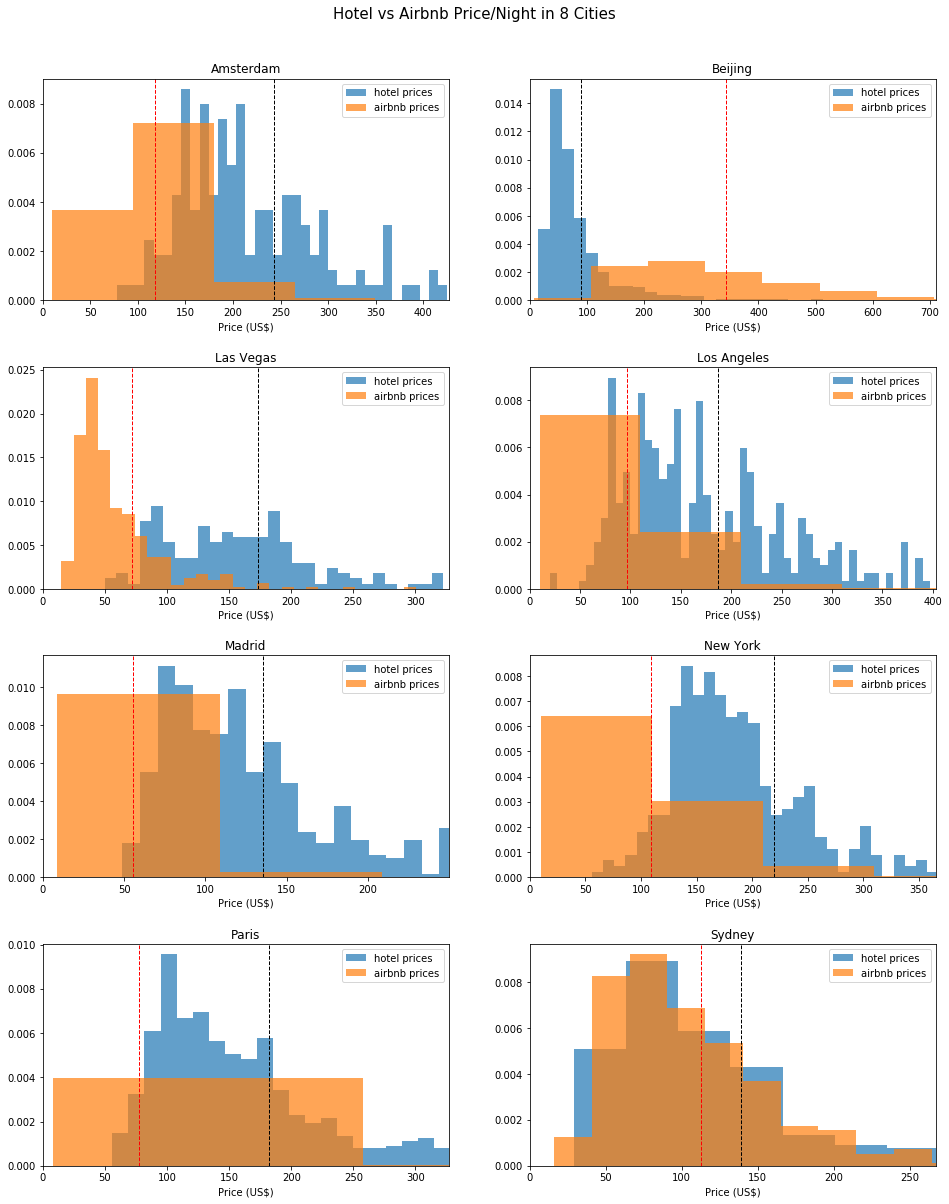

In [22]:
# plot city price spreads, check statistical difference

# function to plot by city, cin is subplot index
def plotdata(city, cin):
    # Histogram Plot of Data
    hotdf = hoteldf.loc[hoteldf["key"]==city]
    adf = airdf.loc[airdf["key"]==city]
    plt.subplot(4, 2, cin)
    plt.hist(hotdf['price'], 100, density=True, alpha=0.7, label="hotel prices")
    plt.hist(adf['price'], 100, density=True, alpha=0.7, label="airbnb prices")
    plt.axvline(hotdf['price'].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(adf['price'].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    h75 = np.percentile(hotdf['price'], 75)
    a75 = np.percentile(adf['price'], 75)
    
    if h75>a75:
        x75 = h75
        x25 = np.percentile(hotdf['price'], 25)
    else:
        x75 = a75
        x25 = np.percentile(adf['price'], 25)
    
    xmax = x75 + 1.5 * (x75 - x25)
    plt.xlim(0,xmax)
    plt.xlabel("Price (US$)")
    plt.title(f"{city}")
    
    # do independent t-test
    print(f"{city}:")
    tresults = stats.ttest_ind(hotdf['price'], airdf['price'], equal_var=False)
    print(f't-test pvalue = {tresults[1]}')
    if tresults[1] >.05:
        print('Hotel and Airbnb price differences are NOT statistically significant.')
    else:
        print('Hotel and Airbnb price differences vary significantly - they are not the same.')
    print("---")

plt.figure(figsize=(16,20))

cin= 1
for city in cityL:
    plotdata(city, cin)
    cin+= 1
    
plt.subplots_adjust(hspace=.3)
plt.suptitle("Hotel vs Airbnb Price/Night in 8 Cities",fontsize = 15, y=.93)

# This figure is saved at the path below
# imagepath = os.path.join("hotel-tripadvisor",saveImages","priceHistogramComparisons.png")
# plt.savefig(imagepath)

plt.show()

## How do lodging options vary city to city? 

In addition to price and rating differences discussed above, we found an unexpected Airbnb listing density difference between cities. The square areas of these cities vary widely, so we checked the raw listing count (before filtering) for each city against its geographical area, and found the density in Paris to be "off the chart."

In [26]:
# load size values/listing counts of cities

sizefile = os.path.join("Resources","sizedensity.csv")
sizedf = pd.read_csv(sizefile, index_col="city")
sizedf

,area (km2),height (km),list/sq_km,listing_count,width (km)
city,,,,,
Amsterdam,219.3,23.093845,88.718650,19456,17.026982
Beijing,16810.0,175.778629,1.541999,25921,179.668299
Las Vegas,352.0,31.634010,5.502841,1937,27.851909
Los Angeles,1300.0,47.194780,28.640769,37233,70.286673
Madrid,604.3,26.189575,29.210657,17652,27.958511
New York,783.8,47.074680,63.470273,49748,48.880916
Paris,105.4,18.015094,550.796964,58054,9.627402
Sydney,12370.0,76.322001,2.902910,35909,59.919472


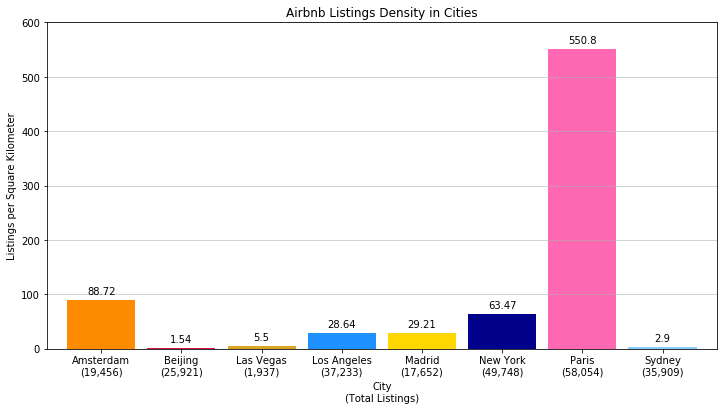

In [29]:
# plot listing density

plt.figure( figsize=(12,6))
myplot = sizedf["list/sq_km"].plot(kind='bar', width=.85, color = colordict.values())
cities = list(sizedf.index.values)
totalcounts = sizedf['listing_count'].tolist()
xticklabels = [city+os.linesep+'('+"{:,}".format(num)+')' for city, num in zip(cities, totalcounts)]
plt.xticks(np.arange(8), xticklabels, rotation=0)
plt.xlabel("City"+os.linesep+"(Total Listings)")
plt.grid(axis='y', alpha=.7)
plt.ylabel("Listings per Square Kilometer")
plt.ylim(0,600)
plt.title ("Airbnb Listings Density in Cities")
# Make some labels.
labels = [str(round(s,2)) for s in  sizedf['list/sq_km']]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# This figure is saved at the path below
# imagepath = os.path.join("airbnb","saveImages","AirbnbListingDensity.png")
# plt.savefig(imagepath)

plt.show()

## Analysis

As mentioned above, lodging prices vary significantly from city to city (ANOVA tests can be found in airbnb and hotel-tripadvisor notebooks). We were unable to obtain exhaustive hotel listing information, but considering Airbnb data, there appears to be considerable difference in choice based on the density of available listings.

----

## How does lodging vary within a city, neighborhood to neighborhood?

Our hotel geographical data sample was very limited compared to the Airbnb data, so neighborhood investigation was done mainly with Airbnb data.

In [31]:
# get hotel info with geographical data
hgo_file = os.path.join("hotel-tripadvisor","saveData","hotelgeo.csv")
hotelgeodf = pd.read_csv(hgo_file)

# Plot Hotel Heatmap of City Listings with Intensity by Price, try New York
city ="New York"
citydf=hotelgeodf.loc[hotelgeodf["key"]==city]
locations = citydf[["latitude", "longitude"]]
pricing = citydf["price"]

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pricing,
                                    max_intensity=400, point_radius=5.0)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [33]:
# Plot Airbnb Heatmap of City Listings with Intensity by Price, try New York
city ="New York"
citydf=airdf.loc[airdf["key"]==city]
locations = citydf[["latitude", "longitude"]]
pricing = citydf["price"]

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pricing,
                                    max_intensity=400, point_radius=2)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [34]:
# Map a Chloropleth of Average Nightly Prices by Neighborhood
# remove outliers and add symbol layer for info box showing neighborhood name and mean price

city = "Madrid"
cgeopath=os.path.join("airbnb",city,"neighbourhoods.geojson")

with open(cgeopath,encoding='utf-8', errors='ignore') as json_data:
     neigh = json.load(json_data, strict=False)

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

citydf = airdf.loc[airdf["key"]== city]
citydf = remove_outlier(citydf, 'price')
groupcitydf = citydf.groupby("neighbourhood_cleansed")[['price','review_scores_rating']].mean()
pmax = groupcitydf['price'].max()
pmin = groupcitydf['price'].min()

features= neigh['features']
colors= []
centroids=[]
labels = []

for hood in features:
    nname = hood["properties"]["neighbourhood"]
    coords = hood["geometry"]["coordinates"][0][0]
    
    #get centroid for symbol layer with info box
    centroid = np.asarray(coords).mean(axis=0)
    loc=(centroid[1], centroid[0])
    centroids.append(loc)
    
    try:
        p = groupcitydf.loc[nname]['price']
        c = int(255 * (p-pmin)/(pmax-pmin))
        color = (c,255-c,255-c, 1)
    except (KeyError, ValueError) as e:
        color = (255, 255, 255, 0.0)
    colors.append(color)
    labels.append(nname+": $"+str(int(p)))

#colors
symbol_layer = gmaps.symbol_layer(centroids, info_box_content=labels, fill_color=(0,0,0,.7), stroke_color=colors, stroke_opacity=.7, scale=2)

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure() #center=cen, zoom_level=10)

nlay = gmaps.geojson_layer(neigh,fill_color=colors,stroke_color='white', fill_opacity=.8)
fig.add_layer(nlay)
fig.add_layer(symbol_layer)
fig

# click on the dots for Neighborhood Mean Price Info

Figure(layout=FigureLayout(height='420px'))

## Analysis

Though our data set for hotels is not exhaustive, the New York City heatmap indicates hotel accommodations are concentrated mainly in midtown. By contrast, the New York City heatmap for Airbnb listings shows a more continuous spread throughout the boroughs. Both heatmaps are weighted for price, and it is interesting to see that while central (Manhattan) locations show  higher price, hip neighborhoods such as Williamsburg and Greenpoint show strong with price concentrations that suggest desirability, though they are not as central. High concentrations in outlying areas may indicate these neighborhoods have arrived as destinations in and of themselves.

The chloropleth of Madrid also shows a central price concentration. Since geoJSON files were included in the Airbnb dataset, this kind of mapping proved helpful in understanding neighborhoods in some of the cities. (Note: Certain geoJSOn files, like Amsterdam, failed to load)

----

## Where do people choose to stay - what factors affect this?

We used number of reviews as a marker to indicate the most popular lodging choices in both hotel and Airbnb datasets, and created scatter plots to look for patterns.

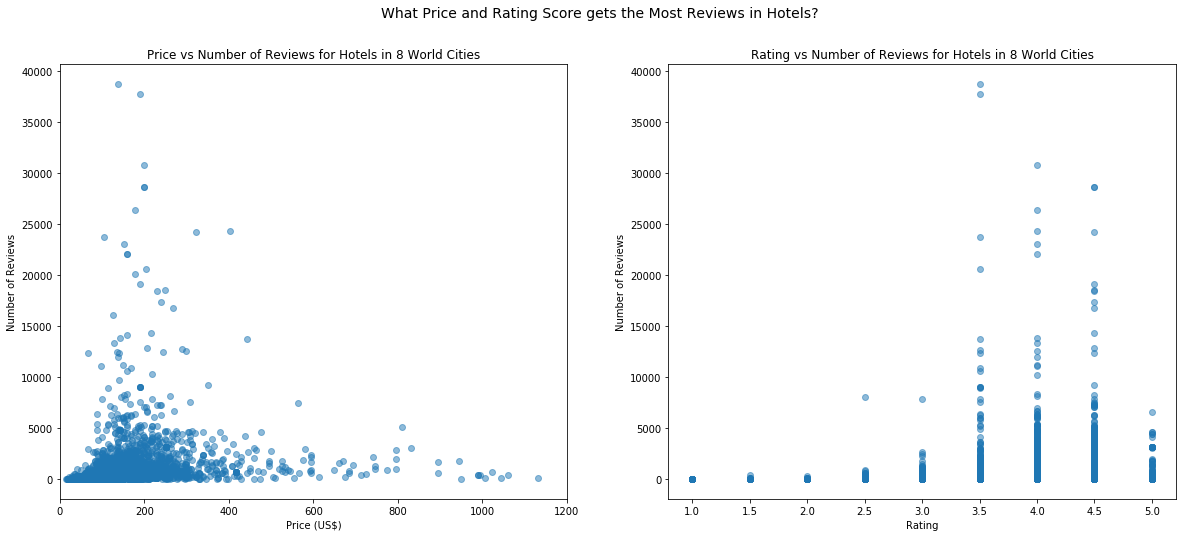

In [35]:
# plot total hotel price and hotel rating against number of reviews for all hotel data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(hoteldf["price"],hoteldf["reviews"], alpha=.5)
ax1.set_title("Price vs Number of Reviews for Hotels in 8 World Cities")
ax1.xaxis.set_label_text('Price (US$)')
ax1.yaxis.set_label_text("Number of Reviews")
ax1.set_xlim(0,1200)

ax2.scatter(hoteldf["rating"],hoteldf["reviews"], alpha=.5)
ax2.set_title("Rating vs Number of Reviews for Hotels in 8 World Cities")
ax2.xaxis.set_label_text('Rating')
ax2.yaxis.set_label_text("Number of Reviews")

fig.suptitle(f"What Price and Rating Score gets the Most Reviews in Hotels?", fontsize=14)

# This figure is saved at the path below
# imagepath = os.path.join("hotel-tripadvisor","saveImages","HotelRatingsScatter.png")
# plt.savefig(imagepath)

fig.show()

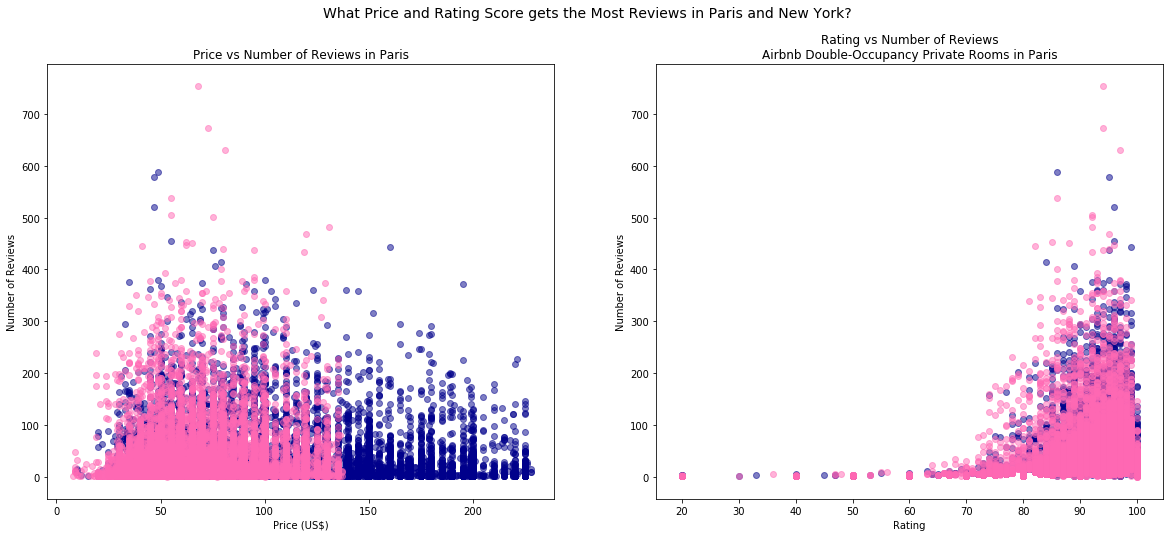

In [36]:
# Look at similar plot for Airbnb listings in Paris and New York

mcity = "Paris"
mcitydf = airdf.loc[airdf['key']==mcity]


altcity = "New York"
altcitydf  = airdf.loc[airdf['key']==altcity]

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

mcitydf = remove_outlier(mcitydf, "price")
color= colordict[mcity]

altcitydf = remove_outlier(altcitydf, "price")
acolor = colordict[altcity]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(altcitydf["price"],altcitydf["number_of_reviews"], c=acolor, alpha=.5)
ax1.scatter(mcitydf["price"],mcitydf["number_of_reviews"], c=color, alpha=.5)
ax1.set_title(f"Price vs Number of Reviews in {mcity}")
ax1.xaxis.set_label_text('Price (US$)')
ax1.yaxis.set_label_text("Number of Reviews")
#ax1.xlim(0,200)

ax2.scatter(altcitydf["review_scores_rating"],altcitydf["number_of_reviews"], c=acolor, alpha=.5)
ax2.scatter(mcitydf["review_scores_rating"],mcitydf["number_of_reviews"], c=color, alpha=.5)
ax2.set_title(f"Rating vs Number of Reviews{os.linesep}Airbnb Double-Occupancy Private Rooms in {mcity}")
ax2.xaxis.set_label_text('Rating')
ax2.yaxis.set_label_text("Number of Reviews")

fig.suptitle(f"What Price and Rating Score gets the Most Reviews in {mcity} and {altcity}?", fontsize=14)

# This figure is saved at the path below
# imagepath = os.path.join("airbnb","saveImages","NumberofRatings.png")
# plt.savefig(imagepath)

fig.show()

## Analysis

The scatter plots indicate a concentration at of low-moderate price and high rating where the most reviews are logged. The AirBnBnotebook file in the airbnb directory contains a scatter plot indicating a specific listing description word count range that coincides with the most reviews. Lodgers appear most attracted to moderately-priced accommodations with high ratings and ample description about the property.

----

## Finally, where should you stay?

Using lower prices, higher ratings, and wider neighborhood location choice as reasons, this analysis would recommend Airbnb lodgings over hotel accommodations for most of the cities. However it is interesting to note that the Airbnb data used here was provided by a website that is essentially against the continued proliferation of Airbnb rentals in cities worldwide.  The site owner provides the data hoping it will be used in conjunction with other information to show how the growth of Airbnb has had detrimental effects on cities.

We did not have the opportunity to obtain other kinds of data to measure the qualitative impact of Airbnb on these destinations, but it is difficult to ignore consistent items in the news that place Airbnb in a negative light. As a final gesture to acknowledge these associations, we used the Google Custom Search API in conjunction with 12 major news websites to create a word cloud based on news headlines returned from the search term "airbnb". This result is below.

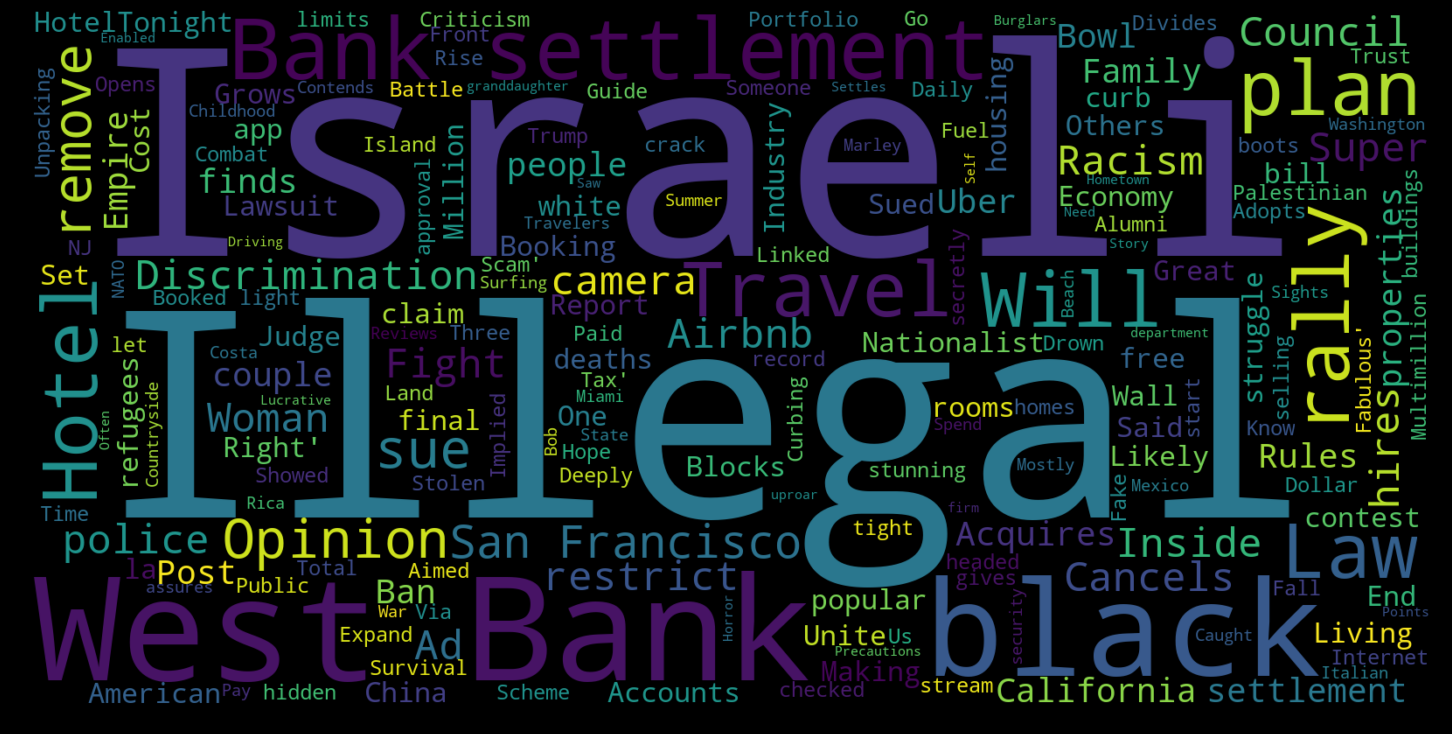

In [40]:
# do a custom search of 12 top Internet news sites with Google Custom Search api
# get title, snippet, and source for response to 'airbnb' query and put in dataframe

params = {
    "key": gkey,
    "cx":"002010857416973848295:kszq0sbcgu8"
}
base_url = "https://www.googleapis.com/customsearch/v1"
params['q'] = 'airbnb'

itemL=[]

# try to get max 100 responses, each call returns 10
for i in range(10):
    params['start'] = i*10+1
    response = requests.get(base_url, params=params).json()
    content=response['items']
    for item in content:
        mdict={}
        mdict['source'] = item["displayLink"]
        mdict['title'] = item["title"]
        mdict['snippet'] = item["snippet"]
        itemL.append(mdict)
        
newsdf = pd.DataFrame(itemL)

titleL = newsdf['title'].tolist()
ttext = " ".join(title for title in titleL)


# Create and generate a word cloud image for news item titles:
# remove common neutral words/news outlet names/months from consideration
stopwords = set(STOPWORDS)
stopwords.update(["new","york","times","cnn","bbc","news","company","rentals","home","rental","Airbnb", "host", "guest", "listing", "apartment", "listings", "says","hosts", "guests","year","city"])
stopwords.update(["Jan","Feb","Mar","April","May","June","July","Aug","Sept","Oct","Nov","Dec"])

wordcloud = WordCloud(width=1600, height=800, background_color="black", stopwords=stopwords).generate(ttext)

# Display the generated image:

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

# one of these is saved at the image path below
newstitlefile = os.path.join("newsTitleCloud.png")
wordcloud.to_file(newstitlefile)